# Customer Lifetime Value (CLV) Analysis

This notebook explores Customer Lifetime Value (CLV) within the synthetic pet insurance dataset.

<small>CLV helps answer key business questions:
- Which customers generate the most value over time?
- How do species, breeds, and products influence long-term profitability?
- Are certain customer segments more likely to renew, claim frequently, or churn?
- How does claim behaviour impact lifetime value?

Data we are using:
1. Total premiums paid
2. Total claims cost
3. Policy duration
4. Renewal behaviour
5. Net lifetime value (premiums – claims)

This notebook forms part of the analytical layer of the project.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load datasets
customers = pd.read_csv(r"C:\Users\leebe\Documents\GitHub\Professional-Portfolio\Pet Insurance Analytics Project\data\raw\customers.csv")
pets = pd.read_csv(r"C:\Users\leebe\Documents\GitHub\Professional-Portfolio\Pet Insurance Analytics Project\data\raw\pets.csv")
policies = pd.read_csv(r"C:\Users\leebe\Documents\GitHub\Professional-Portfolio\Pet Insurance Analytics Project\data\raw\policies.csv")
products = pd.read_csv(r"C:\Users\leebe\Documents\GitHub\Professional-Portfolio\Pet Insurance Analytics Project\data\raw\products.csv")
claims = pd.read_csv(r"C:\Users\leebe\Documents\GitHub\Professional-Portfolio\Pet Insurance Analytics Project\data\raw\claims.csv")
claim_payments = pd.read_csv(r"C:\Users\leebe\Documents\GitHub\Professional-Portfolio\Pet Insurance Analytics Project\data\raw\claim_payments.csv")

print("Datasets loaded successfully.")

Datasets loaded successfully.


# Build CLV Base Table

In [3]:
# Merge policies with products to get premium + limits
policy_product = policies.merge(products, on="product_id", how="left")

# Merge pets to link customers
policy_pet = policy_product.merge(pets[["pet_id", "customer_id", "species", "breed"]], on="pet_id", how="left")

# Merge customers
policy_customer = policy_pet.merge(customers, on="customer_id", how="left")

# Add policy duration in years
policy_customer["policy_duration_years"] = (
    pd.to_datetime(policy_customer["end_date"]) - pd.to_datetime(policy_customer["start_date"])
).dt.days / 365

# Premium paid over lifetime
policy_customer["total_premium_paid"] = policy_customer["monthly_premium"] * 12 * policy_customer["policy_duration_years"]

# Claims paid (sum of payments)
claim_costs = claim_payments.groupby("claim_id")["amount_paid"].sum().reset_index()
claims_with_costs = claims.merge(claim_costs, on="claim_id", how="left").fillna(0)

# Total claims per policy
policy_claims = claims_with_costs.groupby("policy_id")["amount_paid"].sum().reset_index()
policy_claims.rename(columns={"amount_paid": "total_claims_paid"}, inplace=True)

# Merge into main table
clv = policy_customer.merge(policy_claims, on="policy_id", how="left").fillna(0)

# Net Lifetime Value
clv["net_lifetime_value"] = clv["total_premium_paid"] - clv["total_claims_paid"]

clv.head()


,policy_id,pet_id,product_id,start_date,end_date,age_at_policy_start,active,product_name,coverage_type,annual_limit,...,email,phone,address,city,country,created_at,policy_duration_years,total_premium_paid,total_claims_paid,net_lifetime_value
0,1,30289,3,2022-03-19,2024-03-08,1,0,Lifetime Premier,Lifetime,1000,...,lromero@example.net,+1-640-864-1667x881,"01585 Hill Flat, East Barbara, AZ 52829",Richardside,Russian Federation,2018-08-20,1.972603,1359.675616,777.81,581.865616
1,2,45173,6,2021-11-17,2024-11-03,13,0,Lifetime Supreme,Lifetime,8000,...,gomezamy@example.org,+1-444-336-0391,"23595 Sarah Landing Apt. 630, Patrickburgh, AK...",East Sean,Mayotte,2023-01-25,2.964384,1073.936877,541.63,532.306877
2,3,18891,15,2025-07-19,2026-04-08,1,1,Max Benefit 10k,Maximum Benefit,12000,...,charleswright@example.net,001-209-630-5685x3931,"9688 Moore Islands, Buchananfurt, AS 18532",Roytown,Cayman Islands,2018-03-24,0.720548,277.814466,1455.23,-1177.415534
3,4,53368,4,2025-02-02,2025-09-01,3,0,Lifetime Elite,Lifetime,2000,...,alan59@example.net,001-698-871-0539x9406,"4702 Irwin Flats Apt. 202, Clayberg, NC 64051",Woodardberg,Luxembourg,2020-12-20,0.578082,622.108932,2387.88,-1765.771068
4,5,70238,10,2023-07-11,2024-10-05,7,0,Time-Limited Premium,Time-Limited,8000,...,ballardanita@example.org,3685125929,"28570 Tiffany Drives Apt. 942, Castroburgh, LA...",East Jane,Denmark,2020-05-29,1.238356,944.073205,1015.65,-71.576795


# Aggregate CLV at Customer Level

In [4]:
customer_clv = clv.groupby("customer_id").agg({
    "total_premium_paid": "sum",
    "total_claims_paid": "sum",
    "net_lifetime_value": "sum",
    "policy_id": "count",
    "pet_id": "nunique"
}).rename(columns={
    "policy_id": "num_policies",
    "pet_id": "num_pets"
}).reset_index()

customer_clv["avg_policy_value"] = customer_clv["net_lifetime_value"] / customer_clv["num_policies"]

customer_clv.head()


,customer_id,total_premium_paid,total_claims_paid,net_lifetime_value,num_policies,num_pets,avg_policy_value
0,2,1191.481644,0.00,1191.481644,1,1,1191.481644
1,4,408.044712,109.16,298.884712,1,1,298.884712
2,5,3524.659397,402.63,3122.029397,2,1,1561.014699
3,7,1840.854247,2330.46,-489.605753,3,1,-163.201918
4,8,4658.462466,1232.67,3425.792466,3,2,1141.930822


In [5]:
summary = f"""
Customer Lifetime Value Summary
--------------------------------
Total customers analysed: {customer_clv.shape[0]:,}

Average lifetime premium paid: £{customer_clv['total_premium_paid'].mean():.2f}
Average lifetime claims paid: £{customer_clv['total_claims_paid'].mean():.2f}
Average net lifetime value: £{customer_clv['net_lifetime_value'].mean():.2f}

Highest CLV customer: £{customer_clv['net_lifetime_value'].max():.2f}
Lowest CLV customer: £{customer_clv['net_lifetime_value'].min():.2f}

Average number of policies per customer: {customer_clv['num_policies'].mean():.2f}
Average number of pets per customer: {customer_clv['num_pets'].mean():.2f}
"""

print(summary)


Customer Lifetime Value Summary
--------------------------------
Total customers analysed: 43,729

Average lifetime premium paid: £2616.37
Average lifetime claims paid: £2635.49
Average net lifetime value: £-19.12

Highest CLV customer: £10708.45
Lowest CLV customer: £-21467.34

Average number of policies per customer: 2.74
Average number of pets per customer: 1.37



# CLV by species, breed, and product

In [6]:
segment_clv = clv.groupby(["species", "product_name"]).agg({
    "net_lifetime_value": "mean",
    "total_premium_paid": "mean",
    "total_claims_paid": "mean",
    "policy_id": "count"
}).reset_index()
segment_clv


,species,product_name,net_lifetime_value,total_premium_paid,total_claims_paid,policy_id
0,Cat,Accident-Only Basic,-656.270632,258.517026,914.787658,1627
1,Cat,Accident-Only Elite,724.522168,1630.192241,905.670073,1643
2,Cat,Accident-Only Plus,-214.976636,687.669027,902.645663,1637
3,Cat,Dental Care Add-on,648.100071,1568.724924,920.624852,1591
4,Cat,Lifetime Elite,798.015732,1728.220624,930.204892,1670
...,...,...,...,...,...,...
76,Rabbit,Time-Limited Basic,360.944867,1146.576067,785.631200,225
77,Rabbit,Time-Limited Extra,650.967260,1482.552322,831.585062,241
78,Rabbit,Time-Limited Premium,455.141227,1233.248336,778.107109,211
79,Rabbit,Time-Limited Standard,586.769296,1349.590890,762.821595,232


# Visualise CLV distribution

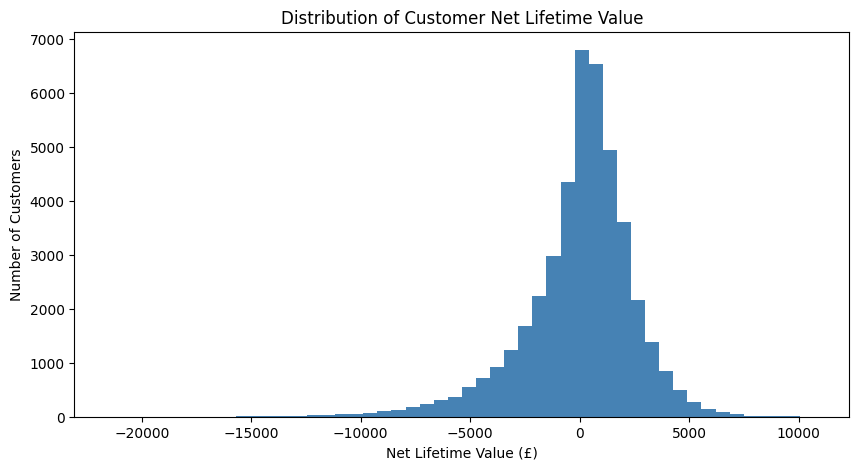

In [7]:
plt.figure(figsize=(10,5))
plt.hist(customer_clv["net_lifetime_value"], bins=50, color="steelblue")
plt.title("Distribution of Customer Net Lifetime Value")
plt.xlabel("Net Lifetime Value (£)")
plt.ylabel("Number of Customers")
plt.show()


# High‑risk / Low‑value segments

In [ ]:
low_value = customer_clv[customer_clv["net_lifetime_value"] < 0]
high_value = customer_clv[customer_clv["net_lifetime_value"] > customer_clv["net_lifetime_value"].quantile(0.9)]

print(f"High CLV customers: {high_value.shape[0]} ({high_value.shape[0]/customer_clv.shape[0]*100:.2f}%)")
print(f"Low CLV customers: {low_value.shape[0]} ({low_value.shape[0]/customer_clv.shape[0]*100:.2f}%)")

Low CLV customers: 18413 (42.11%)
High CLV customers: 4373 (10.00%)


# Which breeds dominate the loss‑making group?

In [9]:
loss_making = clv[clv["net_lifetime_value"] < 0]

breed_losses = (
    loss_making.groupby(["species", "breed"])
    .agg({
        "policy_id": "count",
        "net_lifetime_value": "mean",
        "total_claims_paid": "mean",
        "total_premium_paid": "mean"
    })
    .sort_values("net_lifetime_value")
    .reset_index()
)

breed_losses.head(20)

,species,breed,policy_id,net_lifetime_value,total_claims_paid,total_premium_paid
0,Dog,Border Collie,469,-1690.462593,2387.782751,697.320158
1,Dog,Dachshund,542,-1682.562576,2320.278413,637.715837
2,Dog,Papillon,517,-1651.735767,2351.870368,700.134601
3,Dog,St. Bernard,518,-1642.664917,2310.790869,668.125952
4,Dog,Chihuahua,498,-1633.553436,2364.066807,730.513371
5,Dog,Whippet,484,-1628.055891,2329.746136,701.690246
6,Dog,Shiba Inu,502,-1616.043755,2291.063466,675.019711
7,Dog,Bullmastiff,570,-1615.971563,2322.629596,706.658034
8,Dog,Siberian Husky,521,-1602.730331,2282.088695,679.358364
9,Dog,Poodle,540,-1593.573454,2258.548500,664.975046


# Are multi‑pet households more profitable?

In [10]:
customer_clv["is_multi_pet"] = customer_clv["num_pets"] > 1

multi_pet_analysis = (
    customer_clv.groupby("is_multi_pet")
    .agg({
        "net_lifetime_value": "mean",
        "total_premium_paid": "mean",
        "total_claims_paid": "mean",
        "num_policies": "mean"
    })
    .reset_index()
)

multi_pet_analysis

,is_multi_pet,net_lifetime_value,total_premium_paid,total_claims_paid,num_policies
0,False,-33.563278,1900.783644,1934.346922,1.998181
1,True,15.267706,4319.771705,4304.503999,4.519944


# Are certain products underpriced?

In [11]:
product_profitability = (
    clv.groupby("product_name")
    .agg({
        "net_lifetime_value": "mean",
        "total_premium_paid": "mean",
        "total_claims_paid": "mean"
    })
    .reset_index()
)

product_profitability["claims_ratio"] = (
    product_profitability["total_claims_paid"] /
    product_profitability["total_premium_paid"]
)

product_profitability.sort_values("net_lifetime_value")

,product_name,net_lifetime_value,total_premium_paid,total_claims_paid,claims_ratio
0,Accident-Only Basic,-689.076282,258.275937,947.352219,3.667985
15,Physiotherapy Add-on,-674.998210,274.673362,949.671572,3.457458
11,Max Benefit 1k,-656.915721,310.602573,967.518294,3.114972
12,Max Benefit 3k,-650.030967,300.826333,950.857300,3.160818
14,Max Benefit 7k,-565.202010,384.749357,949.951367,2.469014
17,Rabbit Essential,-476.716641,499.932656,976.649296,1.953562
5,Lifetime Essential,-408.639770,551.070196,959.709966,1.741539
8,Lifetime Supreme,-398.883063,585.608365,984.491428,1.681143
10,Max Benefit 10k,-334.173959,625.051394,959.225353,1.534634
16,Puppy/Kitten Booster,-284.561597,680.823152,965.384749,1.417967


# Summary

Looking at the results above, here are the main take aways i think are valuable.

## Which breeds dominate the loss‑making group?

<small>The top 20 are all dogs which i found interesting. From the list it shows

Large breeds → high claim severity

Small breeds → high claim frequency

Cats → much lower cost base


# Are multi‑pet households more profitable?

<small>Single‑pet households lose money  
CLV = –£33.56

Multi‑pet households make money  
CLV = +£15.27

They pay more total premium

Their claims ratio is slightly better

They’re less price‑sensitive

## Are certain products underpriced?

<small>Every breed listed has negative CLV

Claims paid are 3–4× higher than premiums

Premiums are extremely low (around £650–£730 lifetime)

This means Negative net lifetime value which is something to look at as a business.
